In [3]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Sample implementation of FFNN 

In [4]:
import random
import numpy as np

class DeepFFNN(object):
    """
    Author: Hanbaek Lyu
    Genearal Deep Feedforward Neural Network implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    
    pattern i = [np.array (input), np.array (output)]
    
    TODO: Currently uses square loss. Should be easy to implement other loss functions. 
    """
    def __init__(self, 
                 hidden_layer_sizes,  # input and output layer sizes read off from training data
                 training_data,  # list of patterns [np.array (input), np.array (output)]
                 activation_list=None): # desired list of activation functions in each layer. 
       
        # initialize training data and layer info
        self.training_data = training_data
        self.activation_list = activation_list
        self.list_layer_sizes = [len(self.training_data[0][0]) + 1] + hidden_layer_sizes + [len(self.training_data[0][1])]        
        # add hidden unit in the input layer. No hidden units for the hidden layers. 
        self.n_layers = len(self.list_layer_sizes)-1
        
        self.initialize()
        
    def initialize(self):
        
        # list of activation functions
        if self.activation_list is None:
            activation_list = ['tanh' for i in np.arange(len(self.list_layer_sizes))]
            activation_list[0] = 'identity'  # dummy activation for the input layer
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list

        # default activation of nodes
        node_states = []
        for i in np.arange(len(self.list_layer_sizes)):
            node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
        self.node_states = node_states
        
        # initial weight matrices 
        # use scheme from 'efficient backprop to initialize weights'
        weight_matrices = []
        for i in np.arange(self.n_layers):
            weight_range = 1/(self.list_layer_sizes[i]**(0.5))
            U = np.random.normal(loc = 0, scale = weight_range, size = (self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            weight_matrices.append(U)
            print('weight_matrix.shape', U.shape)
        self.weight_matrices = weight_matrices
           
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        prev_grad_list = []
        for i in np.arange(self.n_layers):
            V = np.zeros((self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            prev_grad_list.append(V)
        self.prev_grad_list = prev_grad_list

    def forwardPropagate(self, inputs):
        # Forward propagate the input using the current weights and update node states 
        self.node_states[0][:-1] = inputs # avoid last coordinate for hidden unit 
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i+1])
            self.node_states[i+1] = X_new
        
        return self.node_states[-1]

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """
    
        error_list = self.node_states.copy()
        # error at the output layer to be backpropagated 
        error = -(np.asarray(targets) - np.asarray(self.node_states[-1]))
        for L in range(self.n_layers, 0, -1): # layer index to be backpropagated 
            # print('L', L)
            if L < self.n_layers: # Not backpropagating from the output layer
                error = self.weight_matrices[L] @ error_list[L+1].reshape(-1,1)
                error = error[:,0] 
            error_list[L] = delta_activation(self.node_states[L], type=self.activation_list[L]) * error
            
        # Compute the gradients
        grad_list = self.weight_matrices.copy()
        for i in np.arange(self.n_layers):
            grad_list[i] = self.node_states[i].reshape(-1,1) @ error_list[i+1].reshape(1,-1) 
        
        return grad_list


    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01, verbose=True):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.forwardPropagate(inputs)
                grad_list = self.backPropagate(targets)
                
                for L in np.arange(self.n_layers):
                    # update the L th weight matrix connecting L th and (L+1)st layers 
                    grad = grad_list[L]
                    prev_grad = self.prev_grad_list[L]
                    self.weight_matrices[L] -= self.learning_rate * grad + self.momentum * prev_grad
                    self.prev_grad_list[L] = grad # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.node_states[-1])**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if (i % 5 == 0) and verbose:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1  
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
        print('X.shape', X.shape)
    
        for i in np.arange(self.n_layers):    
            x = x.T @ self.weight_matrices[i]
            x = activation(x.T, type=self.activation_list[i+1])
            
        print('y_hat.shape', x.shape)
        return x
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y


### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
    elif type == 'softmax-cross-entropy':
        return cross_entropy(y=y, y_hat=softmax(y_hat))
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return tanh(x)
    elif type == 'identity':
        return x
    
def delta_activation(y, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return y*(1-y)
    elif type == 'ReLU':
        return int((y>0))
    elif type == 'tanh':
        return 1-y**2
    elif type == 'identity':
        return 1
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)


def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    return -(y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

## Classifying MNIST images using FFNN

In [5]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [6]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [7]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test


In [8]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix  ===> \n', mcm)
            
    return results_dict

In [9]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels [samples x labels]
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [9]:
# Simple MNIST binary classification experiments 

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1'], full_MNIST=[X,y])
3
# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:], y_train0[i,:])) # don't mind this variable name
    out.append(item)

# FFNN training
NN = DeepFFNN(hidden_layer_sizes=[10], training_data = out)
NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

#NN = MLP_NeuralNetwork_fast(hidden=M, training_data = out)
#NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

# FFNN prediction

X_test /= np.max(X_test)
out_test = []
for i in range(X_test.shape[0]):
    out_test.append(X_test[i,:].tolist())

y_hat = NN.predict(out_test).T
y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)


100%|████████████████████████████████████████████████████████████████████████| 14780/14780 [00:00<00:00, 380642.47it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 2)
iteration 0, error 2.06395
iteration 5, error 0.05365
iteration 10, error 0.04208
iteration 15, error 0.03598
iteration 20, error 0.03199
iteration 25, error 0.02910
iteration 30, error 0.02688
iteration 35, error 0.02510
iteration 40, error 0.02364
iteration 45, error 0.02241
iteration 50, error 0.02135
iteration 55, error 0.02044
iteration 60, error 0.01963
iteration 65, error 0.01891
iteration 70, error 0.01827
iteration 75, error 0.01769
iteration 80, error 0.01716
iteration 85, error 0.01668
iteration 90, error 0.01624
iteration 95, error 0.01584
X.shape (784, 3002)
y_hat.shape (2, 3002)
AUC ===> 1.000
Opt_threshold ===> 0.654
Accuracy ===> 0.998
Sensitivity ===> 0.996
Specificity ===> 0.999
Precision ===> 0.996
Fall_out ===> 0.004
Miss_rate ===> 0.001
Confusion matrix  ===> 
 [[1436    6]
 [   1 1559]]


{'Y_test': array([1, 1, 1, ..., 1, 1, 1]),
 'Y_pred': array([1., 1., 1., ..., 1., 1., 1.]),
 'AUC': 0.9999639923183613,
 'Opt_threshold': 0.6543026991265192,
 'Accuracy': 0.9976682211858761,
 'Sensitivity': 0.9958391123439667,
 'Specificity': 0.9993589743589744,
 'Precision': 0.9961661341853035,
 'Fall_out': 0.004160887656033287,
 'Miss_rate': 0.000641025641025641,
 'Confusion_mx': array([[1436,    6],
        [   1, 1559]], dtype=int64)}

100%|████████████████████████████████████████████████████████████████████████| 34265/34265 [00:00<00:00, 425290.01it/s]


weight_matrix.shape (785, 2)
weight_matrix.shape (2, 5)
iteration 0, error 5.49211
iteration 5, error 3.95916
iteration 10, error 3.86064
iteration 15, error 3.81281
iteration 20, error 3.78447
iteration 25, error 3.76608
iteration 30, error 3.75351
iteration 35, error 3.74452
iteration 40, error 3.73786
iteration 45, error 3.73282
iteration 50, error 3.72899
iteration 55, error 3.72591
iteration 60, error 3.72337
iteration 65, error 3.72132
iteration 70, error 3.71960
iteration 75, error 3.71815
iteration 80, error 3.71690
iteration 85, error 3.71584
iteration 90, error 3.71490
iteration 95, error 3.71407

X.shape (784, 10)
y_hat.shape (5, 10)
X.shape (784, 6934)
y_hat.shape (5, 6934)
!!! confusion_mx [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 2 0]
 [0 0 0 4 0]
 [0 0 0 2 0]]
!!! Accuracy 0.4
!!! confusion_mx [[   0    0    0 1273    0]
 [   0    0    0 1376    0]
 [   0    0    0 1519    0]
 [   0    0    0 1360    0]
 [   0    0    0 1406    0]]
!!! Accuracy 0.1961349870204788
weight_matrix.s

iteration 30, error 0.48973
iteration 35, error 0.43308
iteration 40, error 0.39072
iteration 45, error 0.35758
iteration 50, error 0.33093
iteration 55, error 0.30895
iteration 60, error 0.29048
iteration 65, error 0.27465
iteration 70, error 0.26097
iteration 75, error 0.24898
iteration 80, error 0.23838
iteration 85, error 0.22892
iteration 90, error 0.22042
iteration 95, error 0.21276

X.shape (784, 50)
y_hat.shape (5, 50)
X.shape (784, 6934)
y_hat.shape (5, 6934)
!!! confusion_mx [[ 7  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0  8]]
!!! Accuracy 1.0
!!! confusion_mx [[ 675  282   93  183   40]
 [   5 1331    2   38    0]
 [   9   14 1411   20   65]
 [  60  104   70 1082   44]
 [  23   63  221   35 1064]]
!!! Accuracy 0.8022786270550909
weight_matrix.shape (785, 20)
weight_matrix.shape (20, 5)
iteration 0, error 20.68217
iteration 5, error 2.34319
iteration 10, error 1.25235
iteration 15, error 0.85190
iteration 20, error 0.65388
iteration 25, e

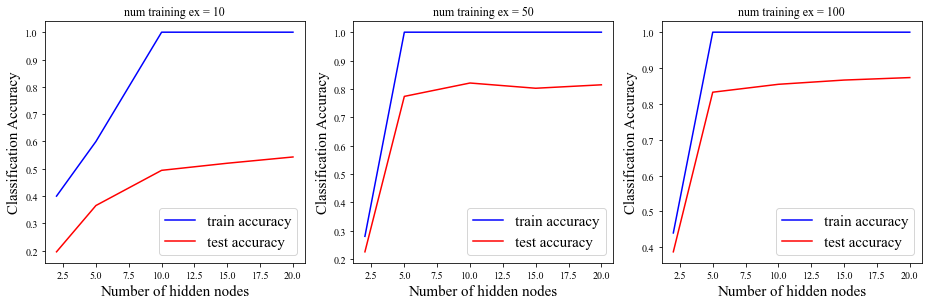

In [10]:
# compute comparative multiclass classification metrics on test data

M_list = [2, 5, 10, 15, 20]
list_digits=['5','6','7','8','9']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST=[X,y])

## Train
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
        out.append(item)
        out_train.append(X_train0[i,:].tolist())

    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test.shape[0]):
        out_test.append(X_test[i,:].tolist())

    for M in M_list:

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes=[M], training_data = out)
        NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(M_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(M_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of hidden nodes', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_ex1.pdf')

100%|████████████████████████████████████████████████████████████████████████| 70000/70000 [00:00<00:00, 454931.29it/s]


weight_matrix.shape (785, 2)
weight_matrix.shape (2, 10)
iteration 0, error 10.45599
iteration 5, error 5.39427
iteration 10, error 4.95042
iteration 15, error 4.75409
iteration 20, error 4.63920
iteration 25, error 4.56300
iteration 30, error 4.50831
iteration 35, error 4.46681
iteration 40, error 4.43420
iteration 45, error 4.40784
iteration 50, error 4.38604
iteration 55, error 4.36764
iteration 60, error 4.35193
iteration 65, error 4.33831
iteration 70, error 4.32638
iteration 75, error 4.31584
iteration 80, error 4.30644
iteration 85, error 4.29801
iteration 90, error 4.29041
iteration 95, error 4.28352

X.shape (784, 10)
y_hat.shape (10, 10)
X.shape (784, 14136)
y_hat.shape (10, 14136)
!!! confusion_mx [[3 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
!!! Accuracy 0.3
!!! confusion_mx [[1373    0    0    0    0    0    0    0    0    0]
 [1645    0    0    0    0    0    0    0    0    0]
 [1389    0    0    0 

iteration 15, error 21.33350
iteration 20, error 20.98729
iteration 25, error 20.75286
iteration 30, error 20.59188
iteration 35, error 20.47516
iteration 40, error 20.38544
iteration 45, error 20.31249
iteration 50, error 20.25157
iteration 55, error 20.19808
iteration 60, error 20.15033
iteration 65, error 20.10533
iteration 70, error 20.06391
iteration 75, error 20.02587
iteration 80, error 19.98895
iteration 85, error 19.95359
iteration 90, error 19.91780
iteration 95, error 19.88088

X.shape (784, 50)
y_hat.shape (10, 50)
X.shape (784, 14136)
y_hat.shape (10, 14136)
!!! confusion_mx [[0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 3 1 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 3 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 7 0 0 0]]
!!! Accuracy 0.28
!!! confusion_mx [[   0    0    0    0    0    0 1226  147    0    0]
 [   0    0    0    0    0    0 1510  135    0    0]
 [   0    0    0    0    0    0 1

iteration 75, error 25.53433
iteration 80, error 25.40618
iteration 85, error 25.28715
iteration 90, error 25.18290
iteration 95, error 25.08627

X.shape (784, 100)
y_hat.shape (10, 100)
X.shape (784, 14136)
y_hat.shape (10, 14136)
!!! confusion_mx [[ 0  0  0  0  0  2  0  0  0  5]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  2  0]
 [ 0  0  0  0  0  7  0  0  1  0]
 [ 0  0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10]]
!!! Accuracy 0.56
!!! confusion_mx [[   0    5    0    0    0  950    0   23    3  392]
 [   0 1485    0    0    0   60    0   27   18   55]
 [   0   77    0    0    0  700    0  209   12  391]
 [   0  113    0    0    0  676    0  446   34  161]
 [   0   29    0    0    0  837    0   32    5  536]
 [   0   14    0    0    0  978    0   70    6  150]
 [   0    8    0    0    0  986    0   16    4  369]
 [   0  108   

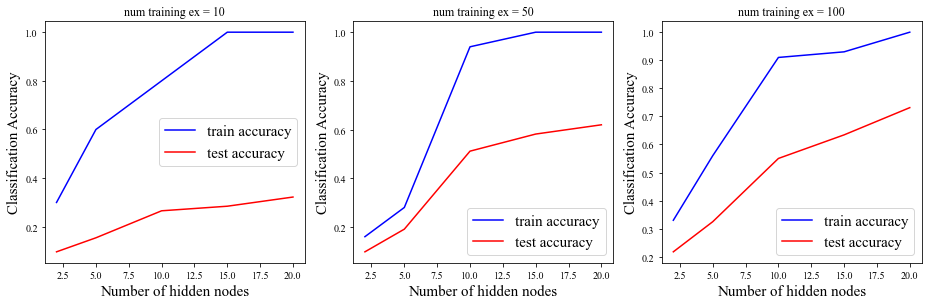

In [11]:
# compute comparative multiclass classification metrics on test data

M_list = [2, 5, 10, 15, 20]
list_digits=['0','1','2','3','4','5','6','7','8','9']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST=[X,y])

## Train
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
        out.append(item)
        out_train.append(X_train0[i,:].tolist())

    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test.shape[0]):
        out_test.append(X_test[i,:].tolist())

    for M in M_list:

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes=[M], training_data = out)
        NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(M_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(M_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of hidden nodes', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

In [51]:
import random
import numpy as np

class MLP(object):
    """
    Author: Hanbaek Lyu
    Multilayer Perceptron (2-layer Feedforward Neural Network) implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    This 2-layer version should be easier to see what's going on than the deep FFNN code. 
    
    pattern i = [np.array (input), np.array (output)]
    
    """
    def __init__(self, 
                 hidden,
                 training_data,
                 lam): #lam is used to denote lambda. if you dont want l2 regularizer, just put lam = 0
       
        # initialize training data
        self.training_data = training_data
        
        #initialize lambda
        self.lam = lam
        
        # initialize layer sizes
        self.input = len(training_data[0][0])+1 # add 1 for bias node
        self.hidden = hidden
        self.output = len(training_data[0][1])

        # set up array of 1s for activations (node states)
        self.ai = np.ones(self.input)
        self.ah = np.ones(self.hidden)
        self.ao = np.ones(self.output)

        # create randomized weights
        # use scheme from 'efficient backprop to initialize weights'
        input_range = 1.0 / self.input ** (1/2)
        output_range = 1.0 / self.hidden ** (1/2)
        self.wi = np.random.normal(loc = 0, scale = input_range, size = (self.input, self.hidden))
        self.wo = np.random.normal(loc = 0, scale = output_range, size = (self.hidden, self.output))
        
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))

    def feedForward(self, inputs):    
        # input activations
        self.ai[:-1] = inputs # -1 is to avoid the bias 
        # hidden activations
        self.ah = tanh(self.ai.T @ self.wi).T # hidden states 
        # output activations
        self.ao = sigmoid(self.ah.T @ self.wo).T # output states 
        
        return self.ao

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """

        # calculate error terms for output
        error = -(np.asarray(targets) - np.asarray(self.ao))
        output_deltas = dsigmoid(np.asarray(self.ao)) * error
        output_deltas.tolist()
        
        # calculate error terms for hidden
        error = self.wo @ output_deltas.reshape(-1,1)
        hidden_deltas = dtanh(self.ah.reshape(-1,1)) * error
        hidden_deltas = hidden_deltas[:,0]
            
        # compute gradients 
        grad1 = self.ah.reshape(-1,1) @ output_deltas.reshape(1,-1)+2*self.lam*self.wo
        grad0 = self.ai.reshape(-1,1) @ hidden_deltas.reshape(1,-1)+2*self.lam*self.wi
        
        return grad0, grad1

    def test(self, patterns):
        """
        Currently this will print out the targets next to the predictions.
        Not useful for actual ML, just for visual inspection.
        """
        for p in patterns:
            print(p[1], '->', self.feedForward(p[0]))

    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.feedForward(inputs)
                grad0, grad1 =self.backPropagate(targets)
            
                # update the weights connecting hidden to output
                self.wo -= self.learning_rate * grad1 + self.momentum * self.co
                self.co = grad1 # store current gradient 

                # update the weights connecting input to hidden
                self.wi -= self.learning_rate * grad0 + self.momentum * self.ci
                self.ci = grad0 # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.ao)**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if i % 5 == 0:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1    
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
       
        W0 = self.wi
        W1 = self.wo 
        z = tanh(x.T @ W0).T # hidden states 
        y_hat = sigmoid((z.T @ W1).T) # output states
        
        if normalize:
            sum_of_cols = y_hat.sum(axis=0)
            y_hat /= sum_of_cols[np.newaxis,:]
        
        return y_hat
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y

100%|████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 441093.15it/s]


iteration 0, error 5.38548
iteration 5, error 4.92437
iteration 10, error 4.89896
iteration 15, error 4.89280
iteration 20, error 4.89098
iteration 25, error 4.88681
iteration 30, error 4.88859
iteration 35, error 4.87960
iteration 40, error 4.87567
iteration 45, error 4.87553
iteration 50, error 4.88078
iteration 55, error 4.87457
iteration 60, error 4.87674
iteration 65, error 4.87479
iteration 70, error 4.87802
iteration 75, error 4.87434
iteration 80, error 4.87343
iteration 85, error 4.87289
iteration 90, error 4.87522
iteration 95, error 4.87400
!!! confusion_mx [[4 0 0 0 0]
 [2 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [2 0 0 0 0]]
!!! Accuracy 0.4
!!! confusion_mx [[1381    0    0    0    0]
 [1606    0    0    0    0]
 [1409    0    0    0    0]
 [1427    0    0    0    0]
 [1332    0    0    0    0]]
!!! Accuracy 0.19301187980433263
iteration 0, error 5.42463
iteration 5, error 4.35764
iteration 10, error 4.33805
iteration 15, error 4.34149
iteration 20, error 4.34836
iteration 25,

iteration 75, error 20.33916
iteration 80, error 20.31076
iteration 85, error 20.35150
iteration 90, error 20.31008
iteration 95, error 20.36241
!!! confusion_mx [[ 0  0  5  0  0]
 [ 0  0 13  0  0]
 [ 0  0 18  0  0]
 [ 0  0  5  0  0]
 [ 0  0  9  0  0]]
!!! Accuracy 0.36
!!! confusion_mx [[   0    0 1381    0    0]
 [   0    0 1606    0    0]
 [   0    0 1409    0    0]
 [   0    0 1427    0    0]
 [   0    0 1332    0    0]]
!!! Accuracy 0.19692522711390636
iteration 0, error 51.03232
iteration 5, error 50.16894
iteration 10, error 50.11392
iteration 15, error 50.13985
iteration 20, error 50.07703
iteration 25, error 50.12080
iteration 30, error 50.13395
iteration 35, error 50.05257
iteration 40, error 50.11272
iteration 45, error 50.06461
iteration 50, error 50.08060
iteration 55, error 50.07912
iteration 60, error 50.05267
iteration 65, error 50.06349
iteration 70, error 50.09914
iteration 75, error 50.05984
iteration 80, error 50.07893
iteration 85, error 50.05766
iteration 90, erro

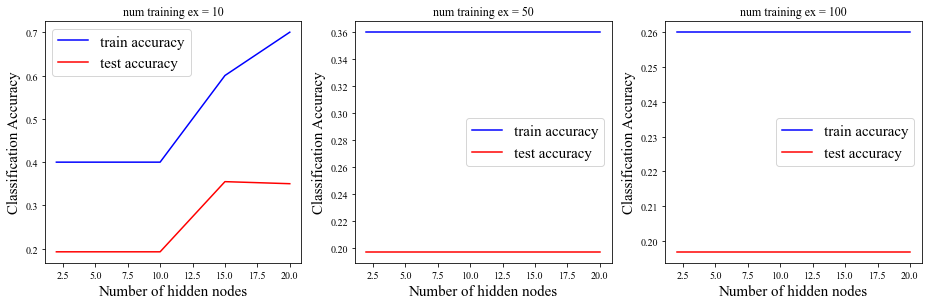

In [57]:
# compute comparative multiclass classification metrics on test data

M_list = [2, 5, 10, 15, 20]
list_digits=['0','1','2','3','4']

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST=[X,y])

## Train
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
        out.append(item)
        out_train.append(X_train0[i,:].tolist())

    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test.shape[0]):
        out_test.append(X_test[i,:].tolist())

    for M in M_list:

        # training
        NN = MLP(hidden=M, training_data = out,lam = 0.1)
        NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(M_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(M_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of hidden nodes', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])